In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing.label import LabelBinarizer
from models import Classifier, Regression
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, df_cv_split
from utils import make_roc_plot
# from crossval import cvpreds_df_chunk_folds

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


TODO:
* setup some way of fixing the folds over which cv is done
* combine features from multiple layers with keras models
* try the gifford ensembl model

## Breakpoints

Calculate the breakpoints inside each regulatory element.

In [3]:
breakpoint_df = get_breakpoint_df(df)
# Save breakpoints to CSV
breakpoint_df.to_csv('data/cagi5_bkpt.csv')
# Look at breakpoints
breakpoint_df[breakpoint_df['is_break']!='no'].head(15)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,start,NaN,True,0.0
47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.45,-2.0100,end,16.0,False,0.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.27,1.9200,start,NaN,True,1.0
95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.32,0.4310,end,16.0,False,1.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.22,0.2990,start,NaN,True,2.0
143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.69,4.6900,end,16.0,False,2.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.08,5.0800,start,NaN,True,3.0
190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.08,1.7900,end,16.0,False,3.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.08,0.0736,start,NaN,True,4.0
235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.55,0.6710,end,16.0,False,4.0


## Cross-validation folds

Split the training data into folds respecting the breakpoints.

In [4]:
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[4], [2], [1], [0], [3]],
 'release_GP1BB': [[2, 0], [3], [5], [1], [4]],
 'release_HBB': [[1], [0], [2], [], []],
 'release_HBG1': [[0], [2], [3], [1], []],
 'release_HNF4A': [[3], [0], [1], [2], []],
 'release_IRF4': [[6, 4], [0, 5], [1, 7], [2], [3]],
 'release_IRF6': [[4, 1], [5, 2], [0, 3], [7, 6], [8]],
 'release_LDLR': [[0], [1], [4], [3], [2]],
 'release_MSMB': [[5, 8], [4, 2], [6, 1], [3, 7], [0]],
 'release_MYCrs6983267': [[3, 1], [7, 4], [2, 0], [8, 5], [6]],
 'release_PKLR': [[4, 1], [5, 3], [2, 6], [0], [7]],
 'release_SORT1': [[2, 5], [8, 0], [7, 4], [6, 3], [1]],
 'release_TERT-GBM': [[2], [1], [0], [4], [3]],
 'release_TERT-HEK293T': [[1], [4], [3], [2], [0]],
 'release_ZFAND3': [[1, 6, 5], [9, 10], [0, 3], [7, 2], [4, 8]]}

## Create features

In [ ]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
enhancer1hot = EnhancerOneHot()
deepE1h = MultiFeatures([deepseadiffs, enhancer1hot])
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()

## Logistic regression

Fit a logistic regression classifier to DeepSeaSNP features.

In [5]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepseadiffs, 'model_name': 'lr'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

[-1  0  1]
[0.61219341 0.54705299 0.6195311 ]


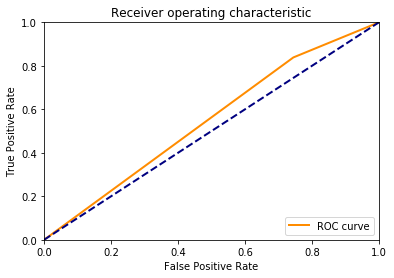

In [6]:
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf_chunk['class'])
print(binarizer.classes_)
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [7]:
cvdf_chunk

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,PredClass,is_break,chunk_length,is_start,chunk_id,is_train
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,-1.0,start,NaN,True,0,True
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.470,3.93,1.4900,-1.0,no,NaN,False,0,True
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.470,3.93,1.4900,-1.0,no,NaN,False,0,True
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.470,3.93,0.3370,-1.0,no,NaN,False,0,True
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.470,3.93,0.3370,-1.0,no,NaN,False,0,True
5,X,138612670,A,T,0.12,0.03,0,release_F9,0.008,0.470,3.93,0.3370,-1.0,no,NaN,False,0,True
6,X,138612671,T,A,0.06,0.02,0,release_F9,0.009,-0.404,3.93,-0.8070,1.0,no,NaN,False,0,True
7,X,138612671,T,C,0.26,0.21,1,release_F9,0.009,-0.404,3.93,-0.8070,-1.0,no,NaN,False,0,True
8,X,138612671,T,G,0.08,0.01,0,release_F9,0.009,-0.404,3.93,-0.8070,0.0,no,NaN,False,0,True
9,X,138612672,C,A,-0.13,0.05,0,release_F9,0.011,-0.251,3.93,0.6860,-1.0,no,NaN,False,0,True


## XGBoost

In [36]:
# features = MultiFeatures([deepseadiffs, enhancer1hot, snpcontext4, conservation])
features = deepseadiffs
cv_chunk = ChunkCV(df,
                   Regression,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
cv_regress.to_csv('data/regress.csv')
cv_regress.sample(6)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,PredClass,PredValue,PredConfidence,is_break,chunk_length,is_start,chunk_id,is_train
2092,10,51549085,T,C,0.00,0.00,0,release_MSMB,0.028,-0.375,2.61,-3.470,NaN,0.288983,0.418433,no,NaN,False,0,False
2532,8,128413078,A,G,-0.01,0.00,0,release_MYCrs6983267,0.153,0.530,5.16,1.350,NaN,0.022453,0.542171,no,NaN,False,0,True
4102,5,1295328,C,A,0.03,0.00,0,release_TERT-HEK293T,0.001,-0.671,1.75,-3.510,NaN,0.206623,0.286241,start,NaN,True,3,True
2153,10,51549121,A,T,0.06,0.04,0,release_MSMB,0.001,-0.456,2.53,-0.744,NaN,0.269903,0.310029,no,NaN,False,1,True
2916,8,128413655,T,C,0.00,0.00,0,release_MYCrs6983267,0.895,0.530,5.47,5.470,NaN,-0.124654,0.392900,no,NaN,False,8,True
1856,19,11199909,C,T,0.04,0.02,0,release_LDLR,0.010,0.557,2.88,-2.560,NaN,-0.080629,0.423606,no,NaN,False,0,True


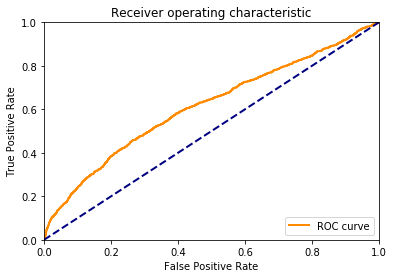

0.6146920649463022


In [37]:
cv_regress['Confidence'].abs() > 0.1
make_roc_plot(cv_regress, 'PredValue')
plt.show()
print(roc_auc_score(cv_regress['class'].abs(), cv_regress['PredValue'].abs()))

In [10]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepseadiffs, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()
cvdf_chunk.sample(6)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,PredClass,PredValue,PredConfidence,is_break,chunk_length,is_start,chunk_id,is_train
1390,6,396580,T,G,0.13,0.02,0,release_IRF4,0.088,0.064,0.00,0.00,0.0,NaN,NaN,no,NaN,False,7,True
4572,6,37775732,G,A,-0.08,0.02,0,release_ZFAND3,0.005,0.581,4.48,3.57,0.0,NaN,NaN,no,NaN,False,8,False
3350,1,109817344,A,C,0.02,0.00,0,release_SORT1,0.996,0.455,4.82,4.82,0.0,NaN,NaN,no,NaN,False,0,True
2242,10,51549199,T,C,-0.01,0.01,0,release_MSMB,0.127,-0.377,3.49,1.04,0.0,NaN,NaN,no,NaN,False,3,True
2665,8,128413315,A,G,0.02,0.01,0,release_MYCrs6983267,0.997,0.530,5.31,5.31,0.0,NaN,NaN,no,NaN,False,3,True
2065,19,11200171,G,C,-0.15,0.04,0,release_LDLR,0.019,0.559,3.67,-1.38,1.0,NaN,NaN,no,NaN,False,4,True


[0.69831437 0.67988242 0.63491668]


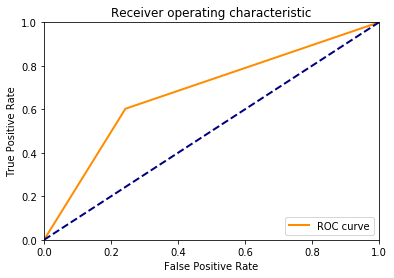

In [11]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

## Enhancer one-hot

One hot encode the identity of the enhancer.

In [12]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': enhancer1hot, 'model_name': 'lr'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/models.py:280: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)


[0.51209774 0.6259887  0.51820821]


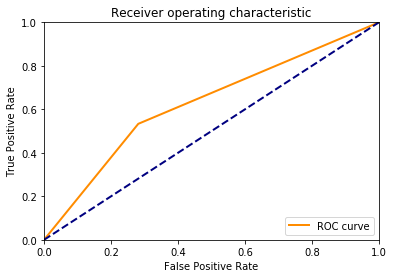

In [13]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [14]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': deepE1h, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/models.py:280: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)
/home/john/Dev/cagimpra/models.py:280: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/models.py:280: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  enhancers = df['regulatory_element'].astype('category', categories=self.enh_names)


[0.69431951 0.67781722 0.64601332]


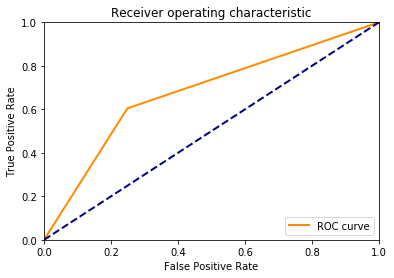

In [15]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [16]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext2, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.4816045  0.52338525 0.55459773]


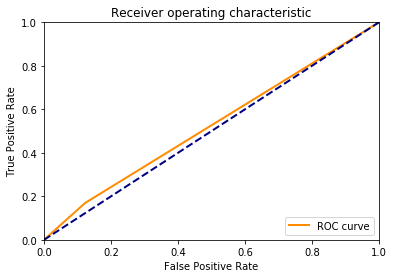

In [17]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [18]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': snpcontext4, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.48854343 0.5153115  0.50723351]


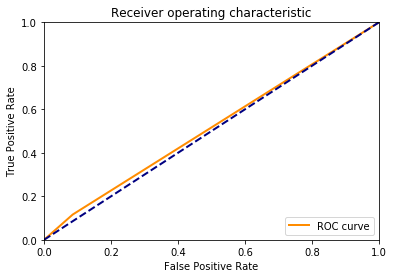

In [19]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [20]:
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': conservation, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.52817263 0.56036418 0.48889774]


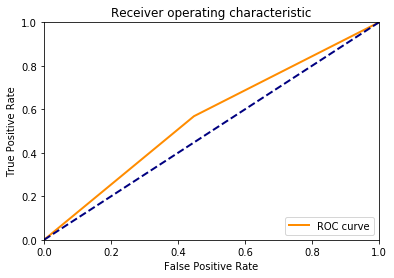

In [21]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [22]:
features = MultiFeatures([conservation, snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.61356044 0.60484043 0.59533249]


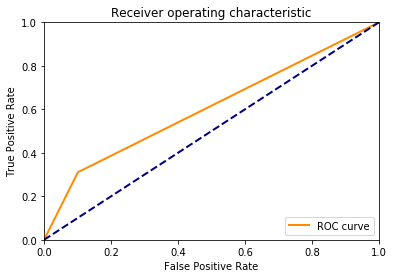

In [23]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [24]:
features = MultiFeatures([conservation, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.69344889 0.67449992 0.62178156]


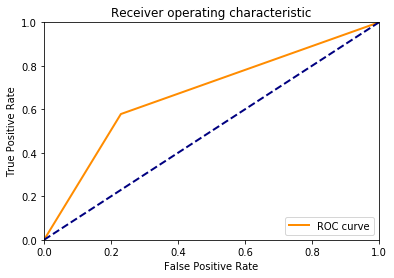

In [25]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [26]:
features = MultiFeatures([snpcontext2, deepseadiffs])
cv_chunk = ChunkCV(df,
                   Classifier,
                   model_kwargs={'features': features, 'model_name': 'xgb'},
                   fold_dict=fold_dict)
cvdf_chunk = cv_chunk.get_cv_preds()

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

[0.61461712 0.60548557 0.60220019]


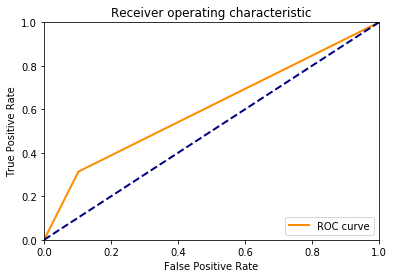

In [27]:
print(roc_auc_score(ybin, binarizer.transform(cvdf_chunk['PredClass']), average=None))
make_roc_plot(cvdf_chunk)
plt.show()

In [28]:
cvdf_chunk[['class', 'Value', 'Confidence']].as_matrix()

array([[ 0.  , -0.17,  0.07],
       [-1.  , -0.26,  0.24],
       [ 0.  ,  0.34,  0.05],
       ...,
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.09,  0.01],
       [ 0.  , -0.06,  0.01]])